# Demo for processing NIRSpec data from DD-2736 (PI: Pontoppidon)

ERO data of the SMACS-0723 field

In [1]:
import os
os.environ['CRDS_CTX'] = 'jwst_1041.pmap'

import glob
import yaml

import numpy as np
import matplotlib.pyplot as plt

import astropy.io.fits as pyfits

import msaexp
from msaexp import pipeline
import grizli.utils


print(f'msaexp version = {msaexp.__version__}')

msaexp version = 0.4.4.dev14+g00d2bcc.d20230201


In [2]:
os.getcwd()

'/usr/local/share/python/msaexp/docs/examples'

# Query MAST for NIRSpec data

Query by program name and download `rate.fits` files with `mastquery`.  May need to set `$MAST_TOKEN` environment variable to enable the downloads from MAST.

Can optionally limit the query to specific 

 - gratings:  ``prism``, ``g140m``, ``g235m``, ``g395m``, ``g140m``, ``g235m``, ``g395m``
 - filters:  ``clear``, ``f170lp``, ``f100lp``, ``f170lp``, ``f290lp``
 - detectors: ``nrs1``, ``nrs2``
 
 

In [3]:
# Query NIRSpec data for a program name
masks = pipeline.query_program(2736, download=True, gratings=['g395m']) #, detectors=['nrs2']) #, gratings=['prism'], detectors=['nrs2'])

2023-02-01 16:54:31,562 - stpipe - INFO - MAST API token accepted, welcome Gabriel Brammer


INFO: MAST API token accepted, welcome Gabriel Brammer [astroquery.mast.auth]


In [4]:
masks['filename','program','filter','grating','detector','msametfl'].to_pandas()

filename  program  filter grating detector  \
0   jw02736007001_03103_00001_nrs1_s2d.fits     2736  F290LP   G395M     NRS1   
1   jw02736007001_03103_00001_nrs2_s2d.fits     2736  F290LP   G395M     NRS2   
2   jw02736007001_03103_00002_nrs1_s2d.fits     2736  F290LP   G395M     NRS1   
3   jw02736007001_03103_00002_nrs2_s2d.fits     2736  F290LP   G395M     NRS2   
4   jw02736007001_03103_00003_nrs1_s2d.fits     2736  F290LP   G395M     NRS1   
5   jw02736007001_03103_00003_nrs2_s2d.fits     2736  F290LP   G395M     NRS2   
6   jw02736008001_03103_00001_nrs1_s2d.fits     2736  F290LP   G395M     NRS1   
7   jw02736008001_03103_00001_nrs2_s2d.fits     2736  F290LP   G395M     NRS2   
8   jw02736008001_03103_00002_nrs1_s2d.fits     2736  F290LP   G395M     NRS1   
9   jw02736008001_03103_00002_nrs2_s2d.fits     2736  F290LP   G395M     NRS2   
10  jw02736008001_03103_00003_nrs1_s2d.fits     2736  F290LP   G395M     NRS1   
11  jw02736008001_03103_00003_nrs2_s2d.fits     2736  F290LP   G395M     NRS2   

                     msametfl  
0   jw02736007001_01_msa.fits  
1   jw02736007001_01_msa.fits  
2   jw02736007001_01_msa.fits  
3   jw02736007001_01_msa.fits  
4   jw02736007001_01_msa.fits  
5   jw02736007001_01_msa.fits  
6   jw02736008001_01_msa.fits  
7   jw02736008001_01_msa.fits  
8   jw02736008001_01_msa.fits  
9   jw02736008001_01_msa.fits  
10  jw02736008001_01_msa.fits  
11  jw02736008001_01_msa.fits

# Initialize pipeline

Exposures are grouped by detector and with a common `MSAMETFL` metadata file for the MSA setup.

In [5]:
import glob
files = glob.glob('jw02736*rate.fits')
files.sort()
groups = pipeline.exposure_groups(files=files)
groups

   N  value     
====  ==========
   3  jw02736007001-01-f290lp-g395m-nrs1
   3  jw02736007001-01-f290lp-g395m-nrs2
   3  jw02736008001-01-f290lp-g395m-nrs1
   3  jw02736008001-01-f290lp-g395m-nrs2


OrderedDict([('jw02736007001-01-f290lp-g395m-nrs1',
              ['jw02736007001_03103_00001_nrs1_rate.fits',
               'jw02736007001_03103_00002_nrs1_rate.fits',
               'jw02736007001_03103_00003_nrs1_rate.fits']),
             ('jw02736007001-01-f290lp-g395m-nrs2',
              ['jw02736007001_03103_00001_nrs2_rate.fits',
               'jw02736007001_03103_00002_nrs2_rate.fits',
               'jw02736007001_03103_00003_nrs2_rate.fits']),
             ('jw02736008001-01-f290lp-g395m-nrs1',
              ['jw02736008001_03103_00001_nrs1_rate.fits',
               'jw02736008001_03103_00002_nrs1_rate.fits',
               'jw02736008001_03103_00003_nrs1_rate.fits']),
             ('jw02736008001-01-f290lp-g395m-nrs2',
              ['jw02736008001_03103_00001_nrs2_rate.fits',
               'jw02736008001_03103_00002_nrs2_rate.fits',
               'jw02736008001_03103_00003_nrs2_rate.fits'])])

## Preprocessing pipeline

1. Run 1/f correction and identify "snowballs" on the `rate.fits` files
2. Remove "bias" (i.e., simple median) of each exposure
3. Run parts of the Level 2 JWST calibration pipeline ([calweb_spec2](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec2.html#calwebb-spec2)):
  - [AssignWcs](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.assign_wcs.AssignWcsStep.html) : initialize WCS and populate slit bounding_box data
  - [Extract2dStep](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.extract_2d.Extract2dStep.html) : identify slits and set slit WCS
  - [FlatFieldStep](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.flatfield.FlatFieldStep.html#flatfieldstep) : slit-level flat field
  - [PathLossStep](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.pathloss.PathLossStep.html) : NIRSpec path loss
  - [PhotomStep](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.photom.PhotomStep.html) : Photometric calibration
  
  Note that the `srctype`, `master_background`, `wavecorr` steps are not performed.  The background subtraction is done manually on the 2D slit cutouts.
  
4. Parse slit metadata
5. Save slit cutout files of the last pipeline step performed (`phot` = `PhotomStep`)

Subsequent re-initialization of the `NirspecPipeline` object and `full_pipeline` method will skip these steps and just load the saved slit cutouts.

In [6]:
# Subset of ids
source_ids = [4590, 6355, 10612, 9239, 6113]

for mode in groups:
    if ('02736' in mode) & (not os.path.exists(f'{mode}.slits.yaml')):
        
        # Run the pipeline to define slits, etc., but don't do extractions yet.  
        pipe = pipeline.NirspecPipeline(mode=mode, source_ids=source_ids, pad=1)
        
        # Pipeline steps
        pipe.full_pipeline(run_extractions=False, initialize_bkg=False, run_flag_open=False)
    else:
        print(f'Skip {mode}')

Skip jw02736007001-01-f290lp-g395m-nrs1
Skip jw02736007001-01-f290lp-g395m-nrs2
Skip jw02736008001-01-f290lp-g395m-nrs1
Skip jw02736008001-01-f290lp-g395m-nrs2


In [7]:
files = glob.glob('*2736*slits.yaml')
files.sort()

all_targets = []
skip = []
for file in files:
    with open(file) as fp:
        slits = yaml.load(fp, Loader=yaml.Loader)
        for k in slits:
            if k.startswith('2736_') & ('m' not in k):
                all_targets.append(k)
            elif k not in skip:
                #print(f'skip {k}')
                skip.append(k)

un = grizli.utils.Unique(all_targets)
targets = un.values
print(len(targets))
#targets

   N  value     
====  ==========
   4  2736_10612
   4  2736_4590 
   4  2736_6113 
   4  2736_6355 
   4  2736_9239 
5


In [8]:
from importlib import reload
from msaexp import pipeline
reload(pipeline)
print(pipeline.__file__)

# # Reinitialize pipeline objects
targets = ['2736_4590', '2736_6355', '2736_10612', '2736_9239', '2736_6113']

gratings = {}
for mode in groups:
    if os.path.exists(f'{mode}.slits.yaml') & ('02736' in mode):
        # Run the pipeline to define slits, etc., but don't do extractions yet.  
        obj = pipeline.NirspecPipeline(mode=mode)
        obj.full_pipeline(run_extractions=False, targets=targets)
        
        if obj.grating not in gratings:
            gratings[obj.grating] = []
        
        gratings[obj.grating].append(obj)

/Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/msaexp/pipeline.py
# (2023-02-01 15:54:31.829)
msaexp.NirspecPipeline: Initialize jw02736007001-01-f290lp-g395m-nrs1
msaexp.NirspecPipeline: jw02736007001_03103_00001_nrs1_rate.fits
msaexp.NirspecPipeline: jw02736007001_03103_00002_nrs1_rate.fits
msaexp.NirspecPipeline: jw02736007001_03103_00003_nrs1_rate.fits
msaexp.NirspecPipeline: mode=jw02736007001-01-f290lp-g395m-nrs1 msametfl=jw02736007001_01_msa.fits
msaexp.read_data: jw02736007001_03103_00001_nrs1_phot.000.2736_9239.fits 2736_9239
msaexp.read_data: jw02736007001_03103_00001_nrs1_phot.001.2736_10612.fits 2736_10612
msaexp.read_data: jw02736007001_03103_00001_nrs1_phot.002.2736_6113.fits background_70
msaexp.read_data: jw02736007001_03103_00001_nrs1_phot.003.2736_6355.fits 2736_6355
msaexp.read_data: jw02736007001_03103_00001_nrs1_phot.004.2736_4590.fits 2736_4590
msaexp.read_data: jw02736007001_03103_00002_nrs1_phot.000.2736_9239.fits 2736_9239
msaexp.read_data: 

msaexp.read_data: jw02736008001_03103_00001_nrs1_phot.003.2736_6355.fits 2736_6355
msaexp.read_data: jw02736008001_03103_00001_nrs1_phot.004.2736_4590.fits 2736_4590
msaexp.read_data: jw02736008001_03103_00002_nrs1_phot.000.2736_9239.fits 2736_9239
msaexp.read_data: jw02736008001_03103_00002_nrs1_phot.001.2736_10612.fits 2736_10612
msaexp.read_data: jw02736008001_03103_00002_nrs1_phot.002.2736_6113.fits background_70
msaexp.read_data: jw02736008001_03103_00002_nrs1_phot.003.2736_6355.fits 2736_6355
msaexp.read_data: jw02736008001_03103_00002_nrs1_phot.004.2736_4590.fits 2736_4590
msaexp.read_data: jw02736008001_03103_00003_nrs1_phot.000.2736_9239.fits 2736_9239
msaexp.read_data: jw02736008001_03103_00003_nrs1_phot.001.2736_10612.fits 2736_10612
msaexp.read_data: jw02736008001_03103_00003_nrs1_phot.002.2736_6113.fits 2736_6113
msaexp.read_data: jw02736008001_03103_00003_nrs1_phot.003.2736_6355.fits 2736_6355
msaexp.read_data: jw02736008001_03103_00003_nrs1_phot.004.2736_4590.fits 2736_4

In [9]:
# Have to run `extract_spectrum` for background subtraction
for key in targets:
    for g in gratings:
        for pipe in gratings[g]:
            print(pipe.mode, key)
            try:
                _ = pipe.extract_spectrum(key, yoffset=0.0, fit_profile_params=None)
                plt.close('all')
            except:
                print('    failed! ')
                plt.close('all')
                continue

2023-02-01 16:55:50,425 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/msaexp/pipeline.py:1077: RuntimeWarning: All-NaN slice encountered
  pscl = np.nanmax(_running[1])



jw02736007001-01-f290lp-g395m-nrs1 2736_4590
jw02736007001-01-f290lp-g395m-nrs2 2736_4590
jw02736008001-01-f290lp-g395m-nrs1 2736_4590
jw02736008001-01-f290lp-g395m-nrs2 2736_4590
jw02736007001-01-f290lp-g395m-nrs1 2736_6355
jw02736007001-01-f290lp-g395m-nrs2 2736_6355
jw02736008001-01-f290lp-g395m-nrs1 2736_6355
jw02736008001-01-f290lp-g395m-nrs2 2736_6355
jw02736007001-01-f290lp-g395m-nrs1 2736_10612
jw02736007001-01-f290lp-g395m-nrs2 2736_10612
jw02736008001-01-f290lp-g395m-nrs1 2736_10612
jw02736008001-01-f290lp-g395m-nrs2 2736_10612
jw02736007001-01-f290lp-g395m-nrs1 2736_9239
jw02736007001-01-f290lp-g395m-nrs2 2736_9239
jw02736008001-01-f290lp-g395m-nrs1 2736_9239
jw02736008001-01-f290lp-g395m-nrs2 2736_9239
jw02736007001-01-f290lp-g395m-nrs1 2736_6113
    failed! 
jw02736007001-01-f290lp-g395m-nrs2 2736_6113
    failed! 
jw02736008001-01-f290lp-g395m-nrs1 2736_6113
    failed! 
jw02736008001-01-f290lp-g395m-nrs2 2736_6113
    failed! 


In [10]:
reload(msaexp.utils)

drizzle_params = {'output':None, 'single':True,
 'pixfrac': 1.0,
 'kernel': 'square',
 'fillval': 0,
 'wht_type': 'ivm',
 'good_bits': 0,
 'pscale_ratio': 1.0,
 'pscale': None}

# Wavelength oversampling relative to grating default
scale = 1.5

# pipes[g].targets


In [11]:
for g in gratings:
    for pipe in gratings[g]:
        print(g, pipe.mode)

f290lp-g395m jw02736007001-01-f290lp-g395m-nrs1
f290lp-g395m jw02736007001-01-f290lp-g395m-nrs2
f290lp-g395m jw02736008001-01-f290lp-g395m-nrs1
f290lp-g395m jw02736008001-01-f290lp-g395m-nrs2


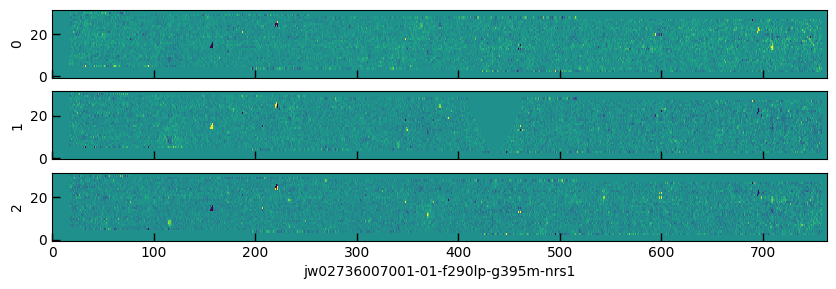

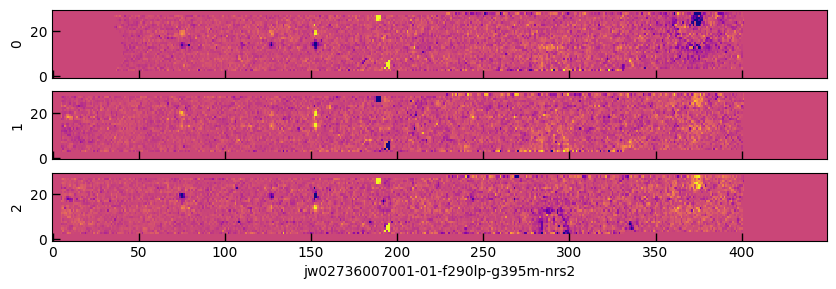

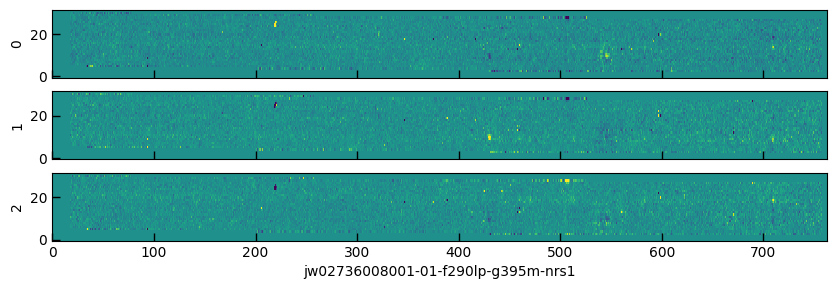

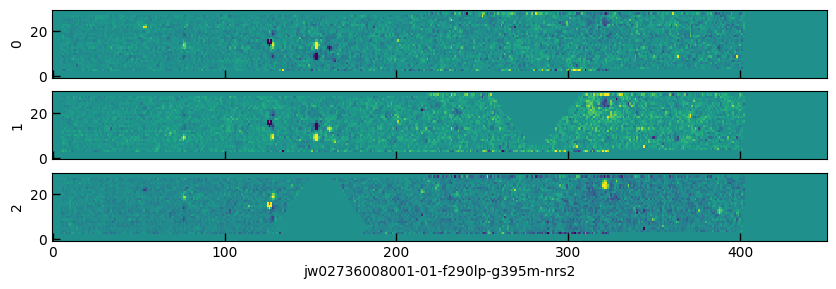

In [12]:
# Look at individual slit cutouts

# 
key = '2736_4590'

hdus = {}
for g in gratings:
    for pipe in gratings[g]:
        _slits = pipe.get_background_slits(key)
        
        fig, axes = plt.subplots(len(_slits), 1, sharex=True, sharey=True, figsize=(10, 3))
        rms = None
        for i, slit in enumerate(_slits):    
            bkg = 0.
            dq = (slit.dq & 1) == 0
            if rms is None:
                rms = grizli.utils.nmad((slit.data - bkg)[dq])
            
            if pipe.mode == 'jw02736007001-01-f290lp-g395m-nrs2':
                cmap = 'plasma_r'
            else:
                cmap = 'viridis'
                
            axes[i].imshow((slit.data - bkg)*dq, vmin=-10*rms, vmax=10*rms, aspect='auto', cmap=cmap)
            axes[i].set_ylabel(i)
            
        axes[i].set_xlabel(pipe.mode)

In [13]:
# Drizzle combinations

reload(msaexp.utils)

key = '2736_4590'

hdus = {}
for g in gratings:
    slits = []
    for pipe in gratings[g]:
        _slits = pipe.get_background_slits(key)
        
        # Stuck closed in jw02736007001-01-f290lp-g395m-nrs2 4590??
        if ('jw02736007001-01-f290lp-g395m' in pipe.mode) & (key == '2736_4590'):
            _p = _slits.pop(1)
            
        if _slits is not None:
            print(f'Add {len(_slits)} slitlets from {pipe.mode}')
            slits.extend(_slits)
            
    print(f'{g} total {len(slits)} slitlets')
    
    output_root = f'smacs0723-{g}_{key}_v3'

    hdus[g] = msaexp.utils.drizzle_2d_pipeline(slits, drizzle_params=drizzle_params,
                                        #profile_slice=slice(int(200*scale), int(600*scale)),
                                        #profile_slice=slice(int(100*scale), int(700*scale)),
                                               profile_slice=None,
                                        standard_waves=scale,
                                        outlier_threshold=5,
                                        output_root=output_root,
                                        fit_prf=True, prf_center=-1., prf_sigma=1.19)

Add 2 slitlets from jw02736007001-01-f290lp-g395m-nrs1
Add 2 slitlets from jw02736007001-01-f290lp-g395m-nrs2
Add 3 slitlets from jw02736008001-01-f290lp-g395m-nrs1
Add 3 slitlets from jw02736008001-01-f290lp-g395m-nrs2
f290lp-g395m total 10 slitlets
build_regular_wavelength_wcs: Set user-defined wavelength grid (size=2020)
Pad 2 pixels on 2D cutout


2023-02-01 16:56:05,441 - stpipe - INFO - Driz parameter kernal: square
2023-02-01 16:56:05,452 - stpipe - INFO - Driz parameter pixfrac: 1.0
2023-02-01 16:56:05,452 - stpipe - INFO - Driz parameter fillval: 0
2023-02-01 16:56:05,456 - stpipe - INFO - Driz parameter weight_type: ivm
2023-02-01 16:56:05,980 - stpipe - INFO - Resampling science data
2023-02-01 16:56:06,039 - stpipe - INFO - Drizzling (32, 764) --> (43, 2020)
2023-02-01 16:56:06,051 - stpipe - INFO - Resampling var_rnoise
2023-02-01 16:56:06,095 - stpipe - INFO - Drizzling (32, 764) --> (43, 2020)
2023-02-01 16:56:06,121 - stpipe - INFO - Resampling var_poisson
2023-02-01 16:56:06,163 - stpipe - INFO - Drizzling (32, 764) --> (43, 2020)
2023-02-01 16:56:06,199 - stpipe - INFO - Resampling var_flat
2023-02-01 16:56:06,253 - stpipe - INFO - Drizzling (32, 764) --> (43, 2020)
2023-02-01 16:56:06,601 - stpipe - INFO - Resampling science data
2023-02-01 16:56:06,662 - stpipe - INFO - Drizzling (32, 764) --> (43, 2020)
2023-02-

fit_prf: center = -0.40. sigma = 0.98


In [14]:
print(g)
hdus[g].info()

f290lp-g395m
Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  SPEC1D        1 BinTableHDU     31   2020R x 3C   ['D', 'D', 'D']   
  2  SCI           1 ImageHDU        34   (2020, 43)   float32   
  3  WHT           1 ImageHDU        34   (2020, 43)   float32   
  4  PROFILE       1 ImageHDU        34   (2020, 43)   float64   
  5  PROF1D        1 BinTableHDU     21   43R x 3C   ['D', 'E', 'D']   


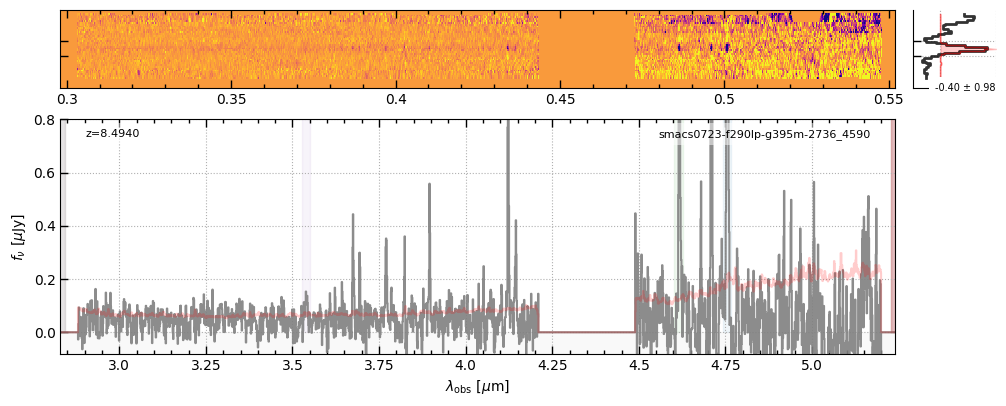

In [15]:
reload(msaexp.utils)
for g in hdus:
    output_root = f'smacs0723-{g}-{key}'
    hdul = hdus[g]
    fig = msaexp.utils.drizzled_hdu_figure(hdul, output_root=output_root, z=8.494, ny=None, ymax=0.8)

    fig.savefig(f'{output_root}.pdf')


Add 2 slitlets from jw02736007001-01-f290lp-g395m-nrs1
Add 2 slitlets from jw02736007001-01-f290lp-g395m-nrs2
smacs0723-007-f290lp-g395m-2736_4590 total 4 slitlets
build_regular_wavelength_wcs: Set user-defined wavelength grid (size=2020)
Pad 2 pixels on 2D cutout


2023-02-01 16:56:13,791 - stpipe - INFO - Driz parameter kernal: square
2023-02-01 16:56:13,798 - stpipe - INFO - Driz parameter pixfrac: 1.0
2023-02-01 16:56:13,799 - stpipe - INFO - Driz parameter fillval: 0
2023-02-01 16:56:13,804 - stpipe - INFO - Driz parameter weight_type: ivm
2023-02-01 16:56:14,305 - stpipe - INFO - Resampling science data
2023-02-01 16:56:14,357 - stpipe - INFO - Drizzling (32, 764) --> (38, 2020)
2023-02-01 16:56:14,374 - stpipe - INFO - Resampling var_rnoise
2023-02-01 16:56:14,423 - stpipe - INFO - Drizzling (32, 764) --> (38, 2020)
2023-02-01 16:56:14,448 - stpipe - INFO - Resampling var_poisson
2023-02-01 16:56:14,492 - stpipe - INFO - Drizzling (32, 764) --> (38, 2020)
2023-02-01 16:56:14,514 - stpipe - INFO - Resampling var_flat
2023-02-01 16:56:14,556 - stpipe - INFO - Drizzling (32, 764) --> (38, 2020)
2023-02-01 16:56:14,913 - stpipe - INFO - Resampling science data
2023-02-01 16:56:14,955 - stpipe - INFO - Drizzling (32, 764) --> (38, 2020)
2023-02-

fit_prf: center = -0.59. sigma = 1.00
Add 3 slitlets from jw02736008001-01-f290lp-g395m-nrs1
Add 3 slitlets from jw02736008001-01-f290lp-g395m-nrs2
smacs0723-008-f290lp-g395m-2736_4590 total 6 slitlets
build_regular_wavelength_wcs: Set user-defined wavelength grid (size=2020)
Pad 2 pixels on 2D cutout


2023-02-01 16:56:17,431 - stpipe - INFO - Driz parameter kernal: square
2023-02-01 16:56:17,436 - stpipe - INFO - Driz parameter pixfrac: 1.0
2023-02-01 16:56:17,442 - stpipe - INFO - Driz parameter fillval: 0
2023-02-01 16:56:17,443 - stpipe - INFO - Driz parameter weight_type: ivm
2023-02-01 16:56:17,960 - stpipe - INFO - Resampling science data
2023-02-01 16:56:18,006 - stpipe - INFO - Drizzling (32, 763) --> (43, 2020)
2023-02-01 16:56:18,027 - stpipe - INFO - Resampling var_rnoise
2023-02-01 16:56:18,093 - stpipe - INFO - Drizzling (32, 763) --> (43, 2020)
2023-02-01 16:56:18,111 - stpipe - INFO - Resampling var_poisson
2023-02-01 16:56:18,165 - stpipe - INFO - Drizzling (32, 763) --> (43, 2020)
2023-02-01 16:56:18,192 - stpipe - INFO - Resampling var_flat
2023-02-01 16:56:18,260 - stpipe - INFO - Drizzling (32, 763) --> (43, 2020)
2023-02-01 16:56:18,602 - stpipe - INFO - Resampling science data
2023-02-01 16:56:18,656 - stpipe - INFO - Drizzling (32, 763) --> (43, 2020)
2023-02-

fit_prf: center = -0.46. sigma = 1.00


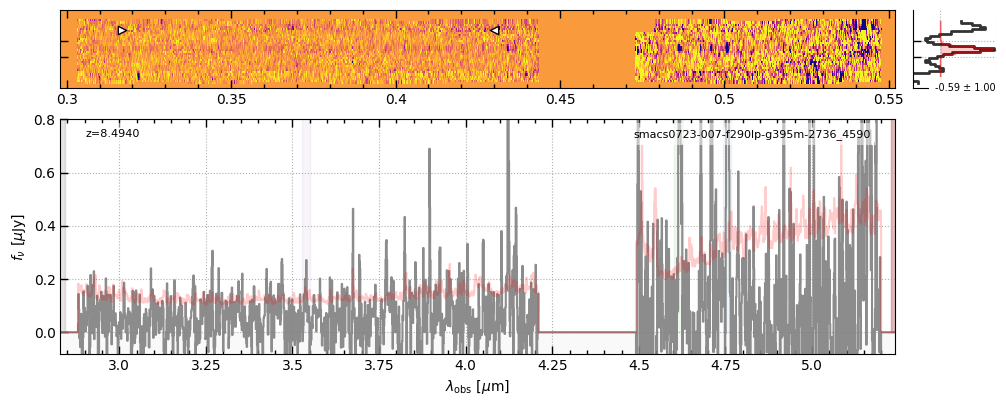

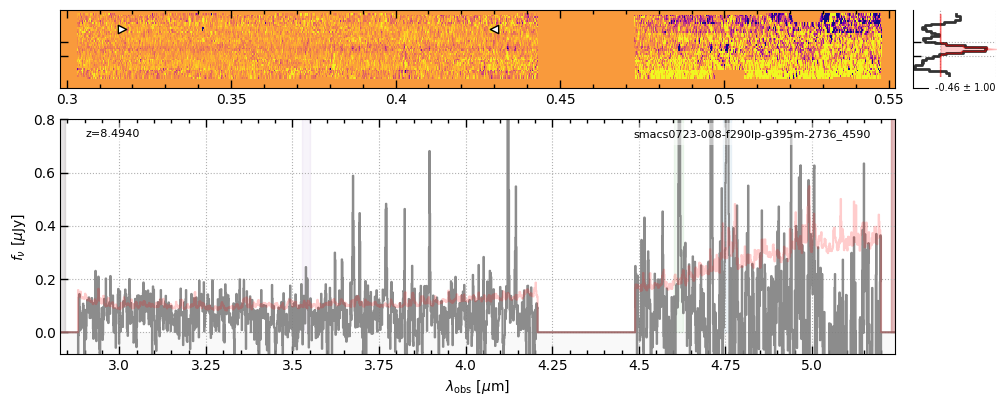

In [16]:
# Drizzle the two visits separately
reload(msaexp.utils)

key = '2736_4590'

ehdus = {}

for exp in ['007','008']:
    for g in gratings:
        slits = []
        for pipe in gratings[g]:
            if f'2736{exp}' not in pipe.mode:
                continue

            _slits = pipe.get_background_slits(key)
            # Stuck closed in jw02736007001-01-f290lp-g395m-nrs2 4590??
            if ('jw02736007001-01-f290lp-g395m' in pipe.mode) & (key == '2736_4590'):
                _p = _slits.pop(1)

            
            if _slits is not None:
                print(f'Add {len(_slits)} slitlets from {pipe.mode}')
                slits.extend(_slits)

        output_root = f'smacs0723-{exp}-{g}-{key}'
        
        print(f'{output_root} total {len(slits)} slitlets')

        ehdus[output_root] = msaexp.utils.drizzle_2d_pipeline(slits, drizzle_params=drizzle_params,
                                            #profile_slice=slice(int(200*scale), int(600*scale)),
                                            profile_slice=slice(int(100*scale), int(700*scale)),
                                            standard_waves=scale,
                                            outlier_threshold=5,
                                            output_root=output_root,
                                            fit_prf=True, prf_center=-1.36, prf_sigma=1.0, fix_sigma=True)

        hdul = ehdus[output_root]
        fig = msaexp.utils.drizzled_hdu_figure(hdul, output_root=output_root, z=8.494, ny=None, ymax=0.8)

        fig.savefig(f'{output_root}.pdf')


(-0.2, 2.0)

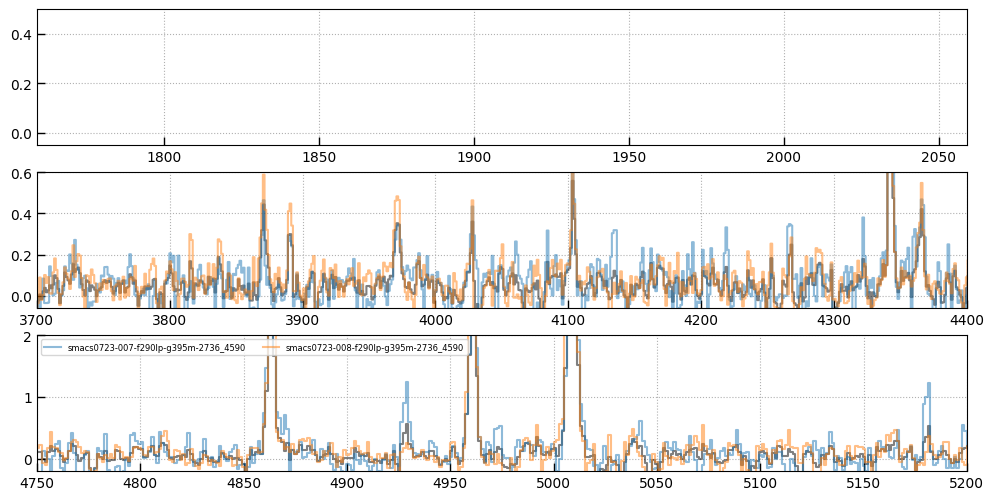

In [17]:
# Compare separate visits
import grizli.utils
fig, axes = plt.subplots(3,1,figsize=(12,6))

for ax in axes:
    for k in hdus:
        sp = grizli.utils.GTable(hdus[k]['SPEC1D'].data)
        ax.step(sp['wave']*1.e4/(1+8.494), sp['flux'], where='mid', alpha=0.5, color='k')

    for k in ehdus:
        sp = grizli.utils.GTable(ehdus[k]['SPEC1D'].data)
        ax.step(sp['wave']*1.e4/(1+8.494), sp['flux'], where='mid', alpha=0.5, label=k)

    ax.grid()

ax.legend(ncol=2, fontsize=6)

ax = axes[0]; ax.set_xlim(1909-150, 1909+150); ax.set_ylim(-0.05,0.5)
ax = axes[1]; ax.set_xlim(3700, 4400); ax.set_ylim(-0.03*2,0.3*2)
ax = axes[2]; ax.set_xlim(4750, 5200); ax.set_ylim(-0.1*2,1*2)


In [18]:
# Drizzle combinations
key = '2736_6355'

reload(msaexp.utils)

hdus = {}
for g in gratings:
    slits = []
    for pipe in gratings[g]:
        _slits = pipe.get_background_slits(key)
        if _slits is not None:
            slits.extend(_slits)
            
    print(g, len(slits))
    
    output_root = f'smacs0723-{g}-{key}'

    hdus[g] = msaexp.utils.drizzle_2d_pipeline(slits, drizzle_params=drizzle_params,
                                        profile_slice=slice(int(200*scale), int(600*scale)),
                                        standard_waves=scale,
                                        outlier_threshold=10,
                                               ypad=2,
                                        output_root=output_root,
                                        fit_prf=True, prf_center=None, prf_sigma=0.9)    

f290lp-g395m 12
build_regular_wavelength_wcs: Set user-defined wavelength grid (size=2020)
Pad 2 pixels on 2D cutout


2023-02-01 16:56:31,502 - stpipe - INFO - Driz parameter kernal: square
2023-02-01 16:56:31,504 - stpipe - INFO - Driz parameter pixfrac: 1.0
2023-02-01 16:56:31,508 - stpipe - INFO - Driz parameter fillval: 0
2023-02-01 16:56:31,509 - stpipe - INFO - Driz parameter weight_type: ivm
2023-02-01 16:56:32,049 - stpipe - INFO - Resampling science data
2023-02-01 16:56:32,482 - stpipe - INFO - Drizzling (45, 1034) --> (57, 2020)
2023-02-01 16:56:32,591 - stpipe - INFO - Resampling var_rnoise
2023-02-01 16:56:33,291 - stpipe - INFO - Drizzling (45, 1034) --> (57, 2020)
2023-02-01 16:56:33,331 - stpipe - INFO - Resampling var_poisson
2023-02-01 16:56:34,128 - stpipe - INFO - Drizzling (45, 1034) --> (57, 2020)
2023-02-01 16:56:34,198 - stpipe - INFO - Resampling var_flat
2023-02-01 16:56:34,674 - stpipe - INFO - Drizzling (45, 1034) --> (57, 2020)
2023-02-01 16:56:35,092 - stpipe - INFO - Resampling science data
2023-02-01 16:56:35,430 - stpipe - INFO - Drizzling (45, 1034) --> (57, 2020)
202

Set prf_center: -1.5 (57, 2020) 17
fit_prf: center = -1.89. sigma = 1.17


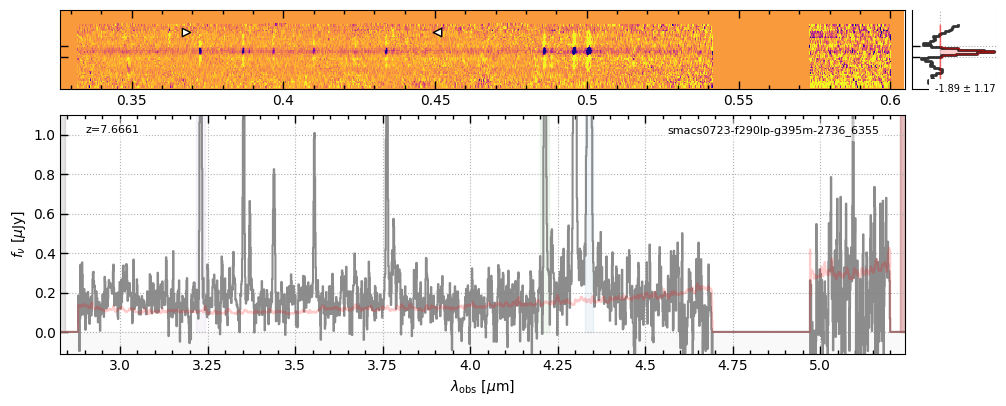

In [19]:
reload(msaexp.utils)
for g in hdus:
    #output_root = f'smacs0723-{g}_{key}_v3'
    output_root = f'smacs0723-{g}-{key}'
    
    hdul = hdus[g]
    fig = msaexp.utils.drizzled_hdu_figure(hdul, output_root=output_root, z=7.6661, ny=None, ymax=1.1)

    fig.savefig(f'{output_root}.pdf')


In [20]:
# Drizzle combinations
key = '2736_10612'

hdus = {}
for g in gratings:
    slits = []
    for pipe in gratings[g]:
        _slits = pipe.get_background_slits(key)
        if _slits is not None:
            slits.extend(_slits)
            
    print(g, len(slits))
    
    output_root = f'smacs0723-{g}-{key}'

    hdus[g] = msaexp.utils.drizzle_2d_pipeline(slits, drizzle_params=drizzle_params,
                                        profile_slice=slice(int(200*scale), int(900*scale)),
                                        standard_waves=scale,
                                        outlier_threshold=10,
                                        output_root=output_root,
                                        fit_prf=True, prf_center=None, prf_sigma=0.95, fix_sigma=True)


f290lp-g395m 12
build_regular_wavelength_wcs: Set user-defined wavelength grid (size=2020)
Pad 2 pixels on 2D cutout


2023-02-01 16:57:01,317 - stpipe - INFO - Driz parameter kernal: square
2023-02-01 16:57:01,324 - stpipe - INFO - Driz parameter pixfrac: 1.0
2023-02-01 16:57:01,329 - stpipe - INFO - Driz parameter fillval: 0
2023-02-01 16:57:01,330 - stpipe - INFO - Driz parameter weight_type: ivm
2023-02-01 16:57:01,874 - stpipe - INFO - Resampling science data
2023-02-01 16:57:02,487 - stpipe - INFO - Drizzling (34, 978) --> (43, 2020)
2023-02-01 16:57:02,530 - stpipe - INFO - Resampling var_rnoise
2023-02-01 16:57:03,036 - stpipe - INFO - Drizzling (34, 978) --> (43, 2020)
2023-02-01 16:57:03,127 - stpipe - INFO - Resampling var_poisson
2023-02-01 16:57:03,761 - stpipe - INFO - Drizzling (34, 978) --> (43, 2020)
2023-02-01 16:57:03,833 - stpipe - INFO - Resampling var_flat
2023-02-01 16:57:04,372 - stpipe - INFO - Drizzling (34, 978) --> (43, 2020)
2023-02-01 16:57:04,785 - stpipe - INFO - Resampling science data
2023-02-01 16:57:05,241 - stpipe - INFO - Drizzling (34, 978) --> (43, 2020)
2023-02-

Set prf_center: -2.5 (43, 2020) 13
fit_prf: center = -2.51. sigma = 0.95


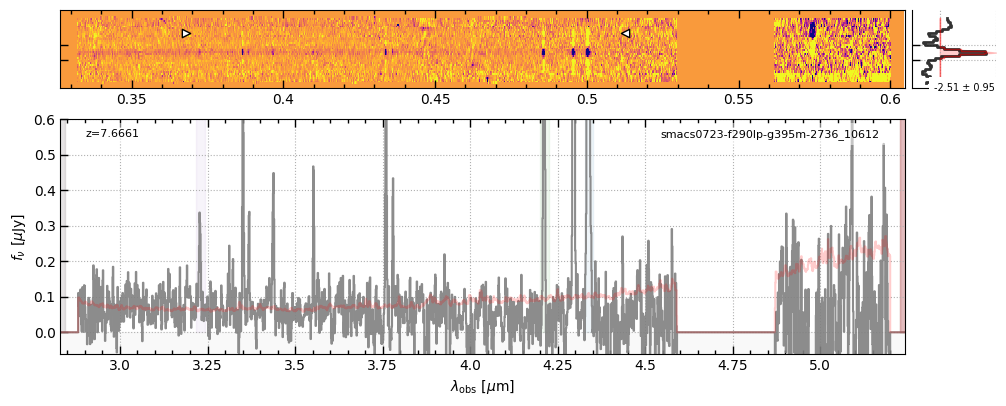

In [21]:
reload(msaexp.utils)
for g in hdus:
    output_root = f'smacs0723-{g}-{key}'
    hdul = hdus[g]
    fig = msaexp.utils.drizzled_hdu_figure(hdul, output_root=output_root, z=7.6661, ny=None, ymax=0.6)


    fig.savefig(f'{output_root}.pdf')


In [22]:
output_root = f'smacs0723-v3-{g}-{key}'
hdus[g].writeto(f'{output_root}.spec.fits', overwrite=True)
print(output_root)

smacs0723-v3-f290lp-g395m-2736_10612


## Fit redshift

In [25]:
from msaexp import spectrum
spectrum.SCALE_UNCERTAINTY = 1.0
spectrum.FFTSMOOTH = False

357it [00:03, 115.55it/s]
501it [00:04, 109.68it/s]



# line flux err
# flux x 10^-20 erg/s/cm2
# smacs0723-v3-f290lp-g395m-2736_10612.spec.fits
# z = 7.65951
# Wed Feb  1 17:00:25 2023
             line Hb      160.5 ±      4.9
             line Hg       86.2 ±      4.5
             line Hd       40.6 ±      4.5
             line H8       31.5 ±      5.0
             line H9       15.1 ±      5.1
            line H10        6.8 ±      5.1
            line H11        6.6 ±      5.0
            line H12       -2.7 ±      5.2
             line H7       27.0 ±      6.6
     line NeIII-3968       24.7 ±      6.4
      line OIII-4959      389.4 ±      6.0
      line OIII-5007     1155.8 ±     11.6
      line OIII-4363       33.0 ±      4.3
            line OII       40.3 ±      6.0
      line HeII-4687        2.7 ±      4.4
     line NeIII-3867       93.9 ±      5.3
       line HeI-5877       35.4 ±      7.4
       line NeV-3346        1.2 ±      9.3
      line NeVI-3426        1.6 ±      7.1


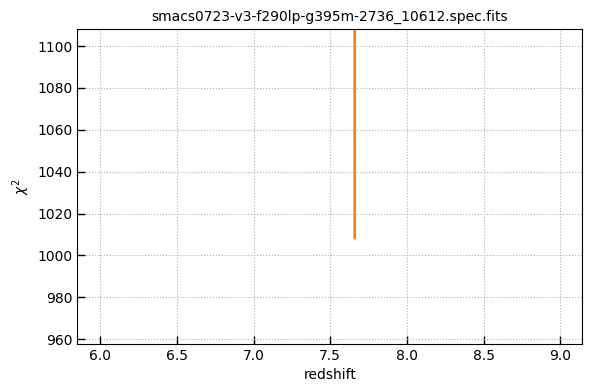

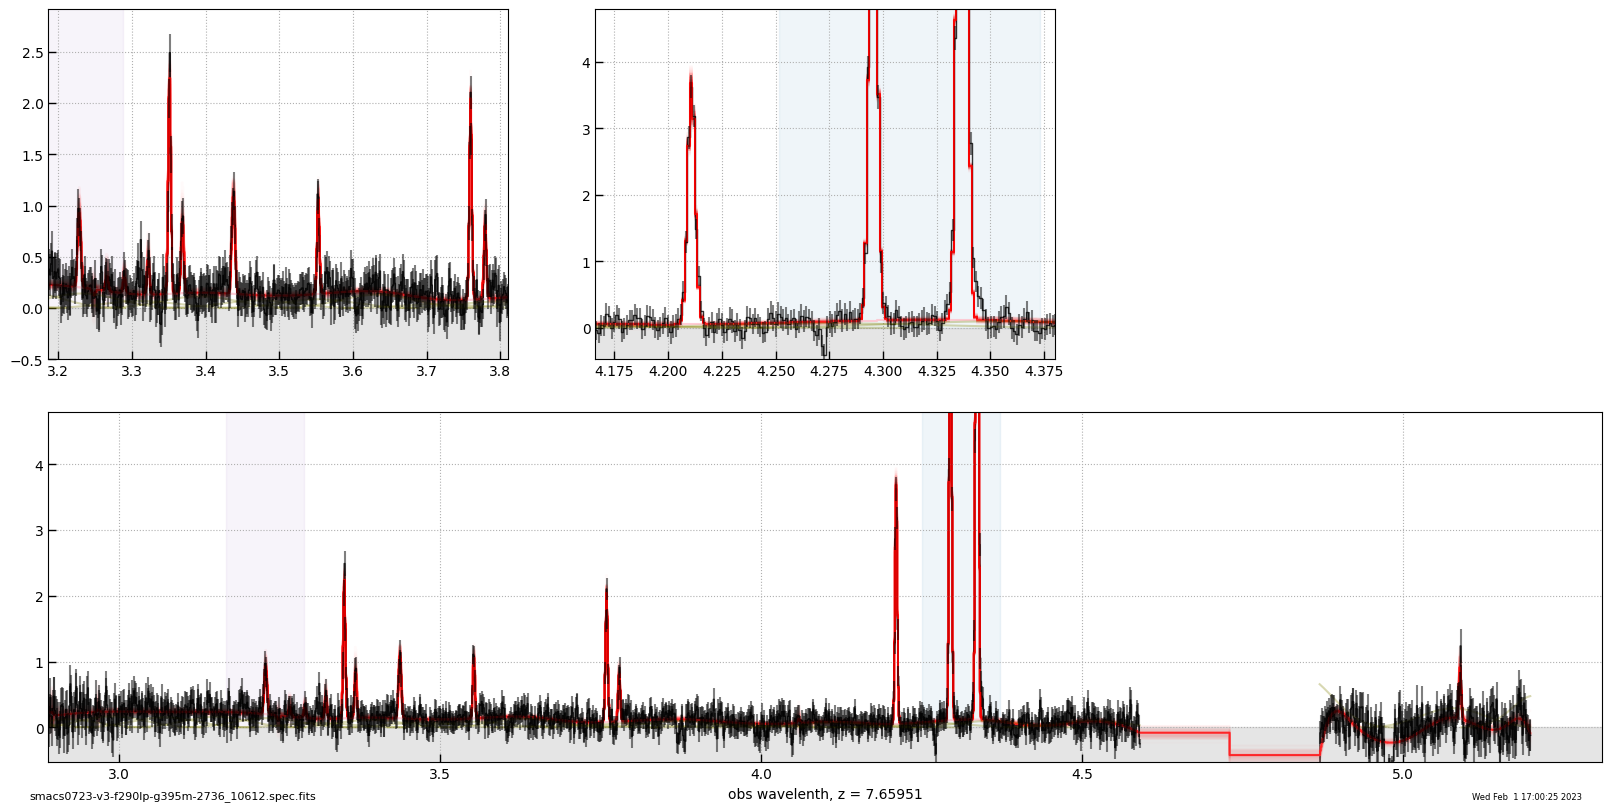

In [27]:

fig, sp, data = spectrum.fit_redshift(file=f'{output_root}.spec.fits',
                          z0=[6,9], 
                          eazy_templates=None,
                          nspline=33,
                          scale_disp=1.0,
                          vel_width=20.,
                          is_prism=False,
                         )

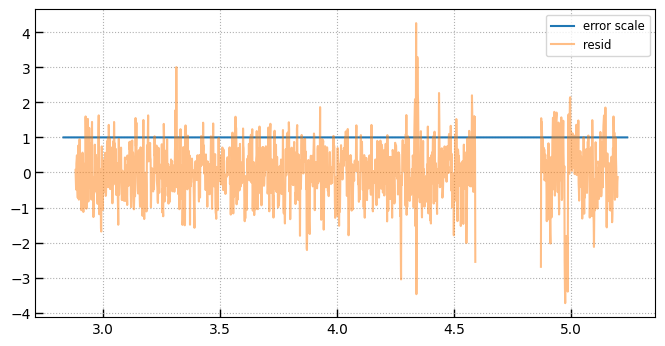

In [28]:
fig, ax = plt.subplots(1,1,figsize=(8,4))
ax.plot(sp['wave'], sp['escale'], label='error scale')
ax.plot(sp['wave'], (sp['flux'] - sp['model']) / sp['full_err'], label='resid', alpha=0.5)
ax.legend()
ax.grid()


Set SCALE_UNCERTAINTY:  [-0.06564124  0.83305354 -3.38719872  4.2534855 ]

# line flux err
# flux x 10^-20 erg/s/cm2
# smacs0723-v3-f290lp-g395m-2736_10612.spec.fits
# z = 7.65951
# Wed Feb  1 17:00:45 2023
             line Hb      160.4 ±      3.5
             line Hg       86.1 ±      2.9
             line Hd       40.6 ±      2.8
             line H8       31.5 ±      3.1
             line H9       15.1 ±      3.1
            line H10        6.8 ±      3.1
            line H11        6.6 ±      3.1
            line H12       -2.7 ±      3.2
             line H7       27.0 ±      4.1
     line NeIII-3968       24.7 ±      3.9
      line OIII-4959      389.2 ±      4.4
      line OIII-5007     1155.7 ±      8.8
      line OIII-4363       32.9 ±      2.8
            line OII       40.3 ±      3.7
      line HeII-4687        2.7 ±      3.1
     line NeIII-3867       93.9 ±      3.2
       line HeI-5877       35.3 ±      6.4
       line NeV-3346        1.0 ±      6.4
      line NeVI-342

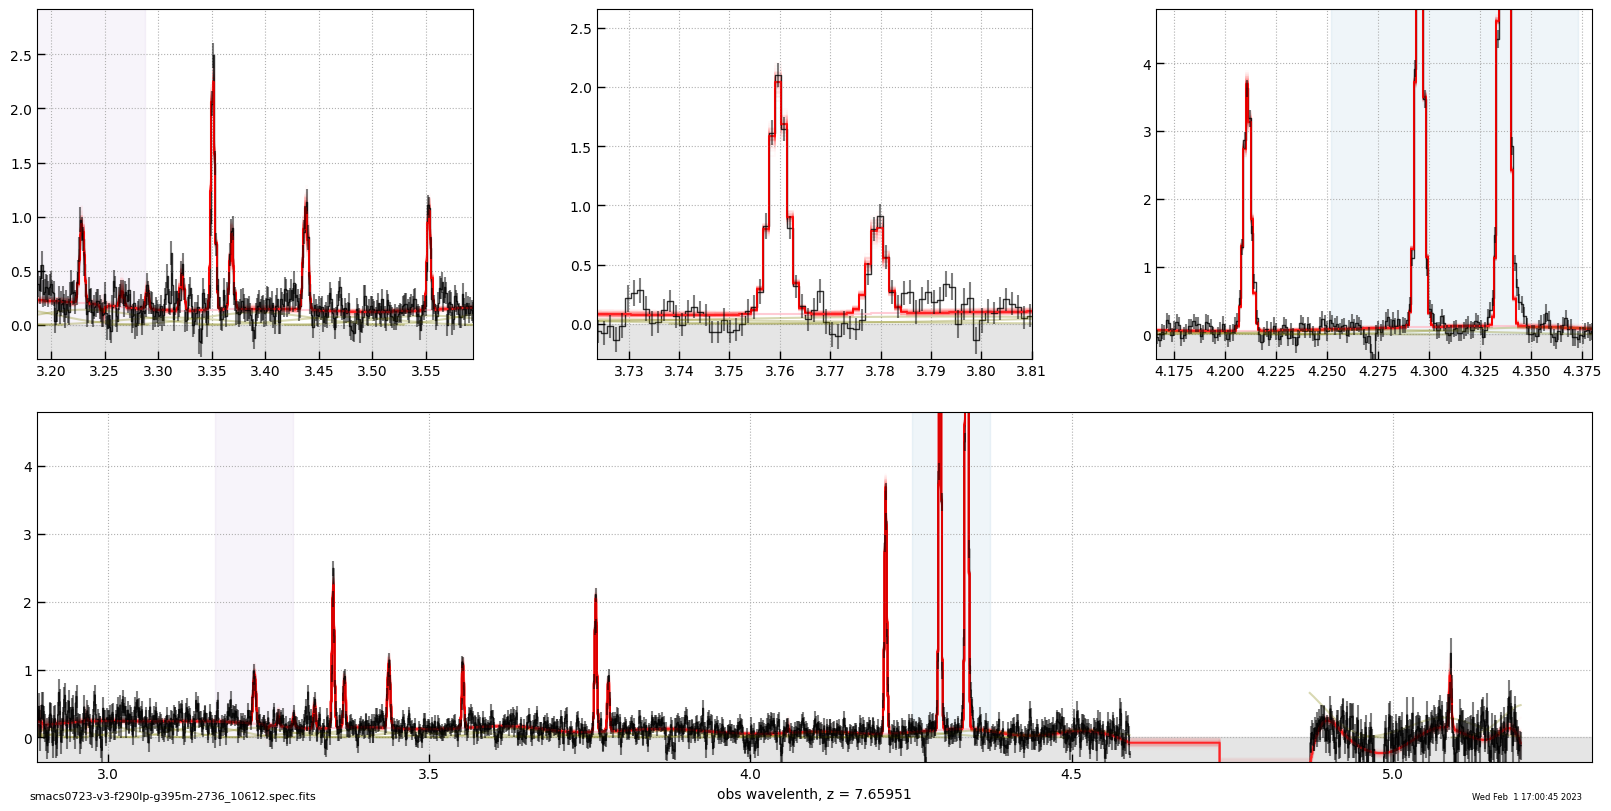

In [31]:
# Rescale uncertainties

spectrum.SCALE_UNCERTAINTY = 1.0

fig, sp, data = spectrum.plot_spectrum(file=f'{output_root}.spec.fits', 
                           z=data['z'],
                          eazy_templates=None,
                          nspline=33,
                          scale_disp=1.0,
                          vel_width=10.,
                          is_prism=False,
                           scale_uncertainty_kwargs={'order':3, 'init':[1,3]},
                           use_full_dispersion=False,
                           Rline=5000,
                           ranges=[(3680, 4150), (4300, 4400), (4861-50, 5008+50)],
                         )

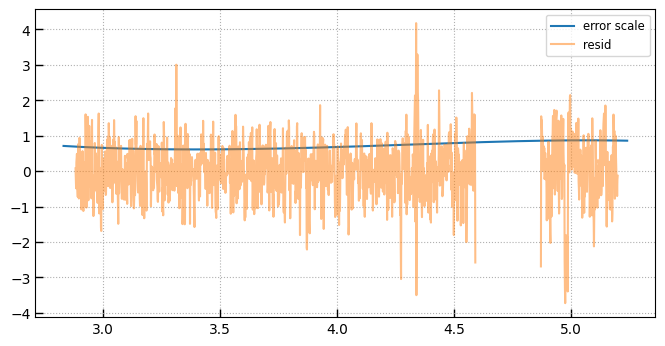

In [32]:
fig, ax = plt.subplots(1,1,figsize=(8,4))
ax.plot(sp['wave'], sp['escale'], label='error scale')
ax.plot(sp['wave'], (sp['flux'] - sp['model']) / sp['full_err'], label='resid', alpha=0.5)
ax.legend()
ax.grid()


357it [00:03, 114.65it/s]
501it [00:04, 108.53it/s]



# line flux err
# flux x 10^-20 erg/s/cm2
# smacs0723-v3-f290lp-g395m-2736_10612.spec.fits
# z = 7.65951
# Wed Feb  1 17:00:58 2023
             line Hb      160.3 ±      3.7
             line Hg       86.1 ±      3.0
             line Hd       40.5 ±      2.8
             line H8       31.4 ±      3.1
             line H9       15.1 ±      3.1
            line H10        6.8 ±      3.1
            line H11        6.6 ±      3.1
            line H12       -2.7 ±      3.2
             line H7       27.0 ±      4.1
     line NeIII-3968       24.7 ±      3.9
      line OIII-4959      388.7 ±      5.1
      line OIII-5007     1154.6 ±     10.9
      line OIII-4363       32.9 ±      2.8
            line OII       40.3 ±      3.7
      line HeII-4687        2.7 ±      3.1
     line NeIII-3867       93.5 ±      3.3
       line HeI-5877       35.3 ±      6.4
       line NeV-3346        1.0 ±      6.4
      line NeVI-3426        1.6 ±      4.7


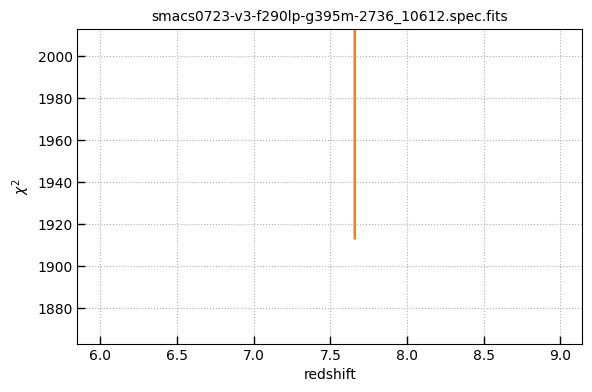

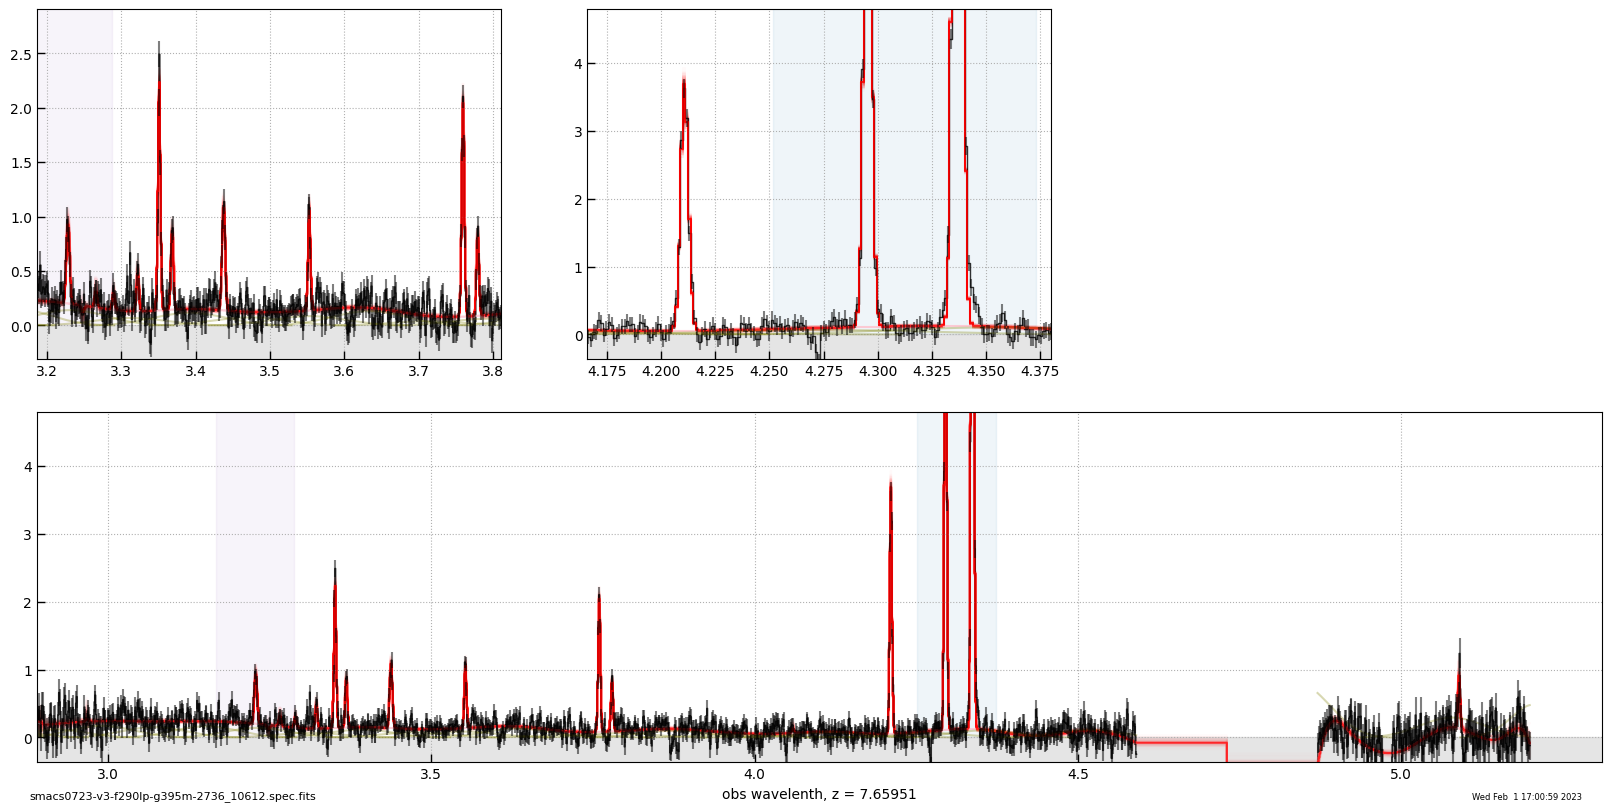

In [33]:
# Refit redshift with scaled uncertainties
_ = spectrum.fit_redshift(file=f'{output_root}.spec.fits', z0=[6,9], 
                          eazy_templates=None,
                          nspline=33,
                          scale_disp=1.0,
                          vel_width=10.,
                          is_prism=False,
                          use_full_dispersion=False
                         )

## Fit redshifts with `eazy` templates

In [34]:
import eazy
reload(eazy)

if not os.path.exists('templates'):
    eazy.symlink_eazy_inputs()
    
otempl = eazy.templates.read_templates_file('templates/sfhz/blue_sfhz_13.param')[:]

templ = [otempl[i].smooth_velocity(3.e5/2500, in_place=False, smoothspec_kwargs={'fftsmooth': False}) 
         for i in [-1]]


2023-02-01 17:01:01,087 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39jw/lib/python3.9/site-packages/eazy/templates.py:356: ResourceWarning: unclosed file <_io.TextIOWrapper name='templates/sfhz/blue_sfhz_13.param' mode='r' encoding='UTF-8'>
  lines = open(templates_file).readlines()



In [35]:
spectrum.FFTSMOOTH = False

357it [00:00, 739.76it/s]
501it [00:00, 742.56it/s]



# line flux err
# flux x 10^-20 erg/s/cm2
# smacs0723-v3-f290lp-g395m-2736_10612.spec.fits
# z = 7.65951
# Wed Feb  1 17:01:03 2023

# line flux err
# flux x 10^-20 erg/s/cm2
# smacs0723-v3-f290lp-g395m-2736_10612.spec.fits
# z = 7.65951
# Wed Feb  1 17:01:03 2023
             line Hb      160.3 ±      3.7
             line Hg       86.1 ±      3.0
             line Hd       40.5 ±      2.8
             line H8       31.4 ±      3.1
             line H9       15.1 ±      3.1
            line H10        6.8 ±      3.1
            line H11        6.6 ±      3.1
            line H12       -2.7 ±      3.2
             line H7       27.0 ±      4.1
     line NeIII-3968       24.7 ±      3.9
      line OIII-4959      388.7 ±      5.1
      line OIII-5007     1154.6 ±     10.9
      line OIII-4363       32.9 ±      2.8
            line OII       40.3 ±      3.7
      line HeII-4687        2.7 ±      3.1
     line NeIII-3867       93.5 ±      3.3
       line HeI-5877       35.3 ±      6.4
   

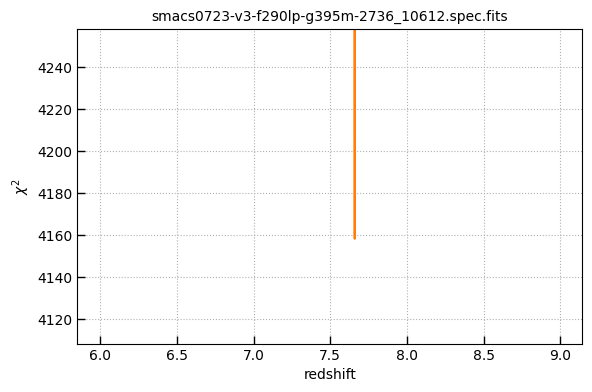

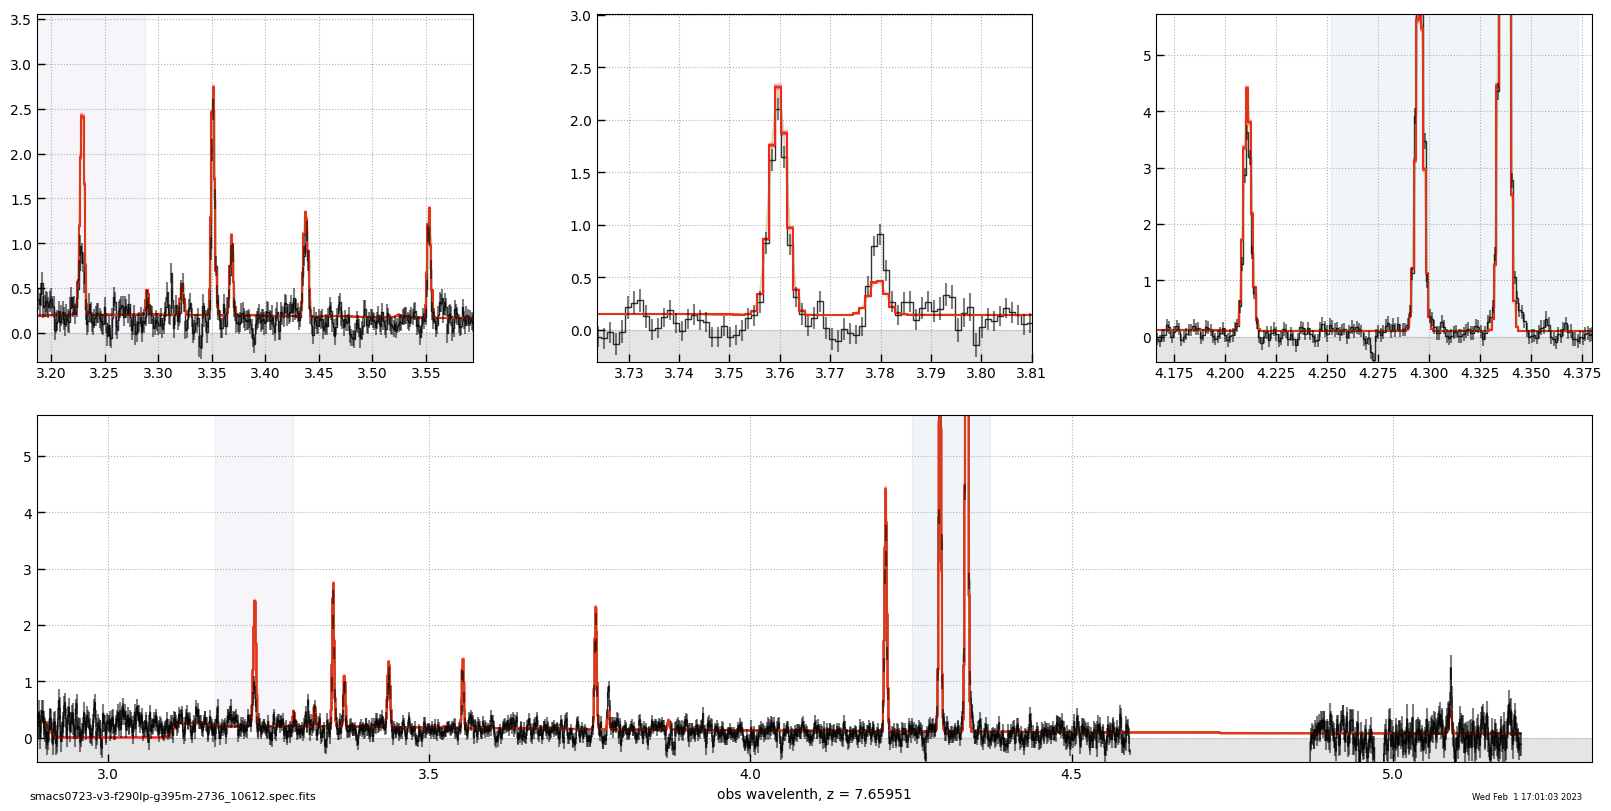

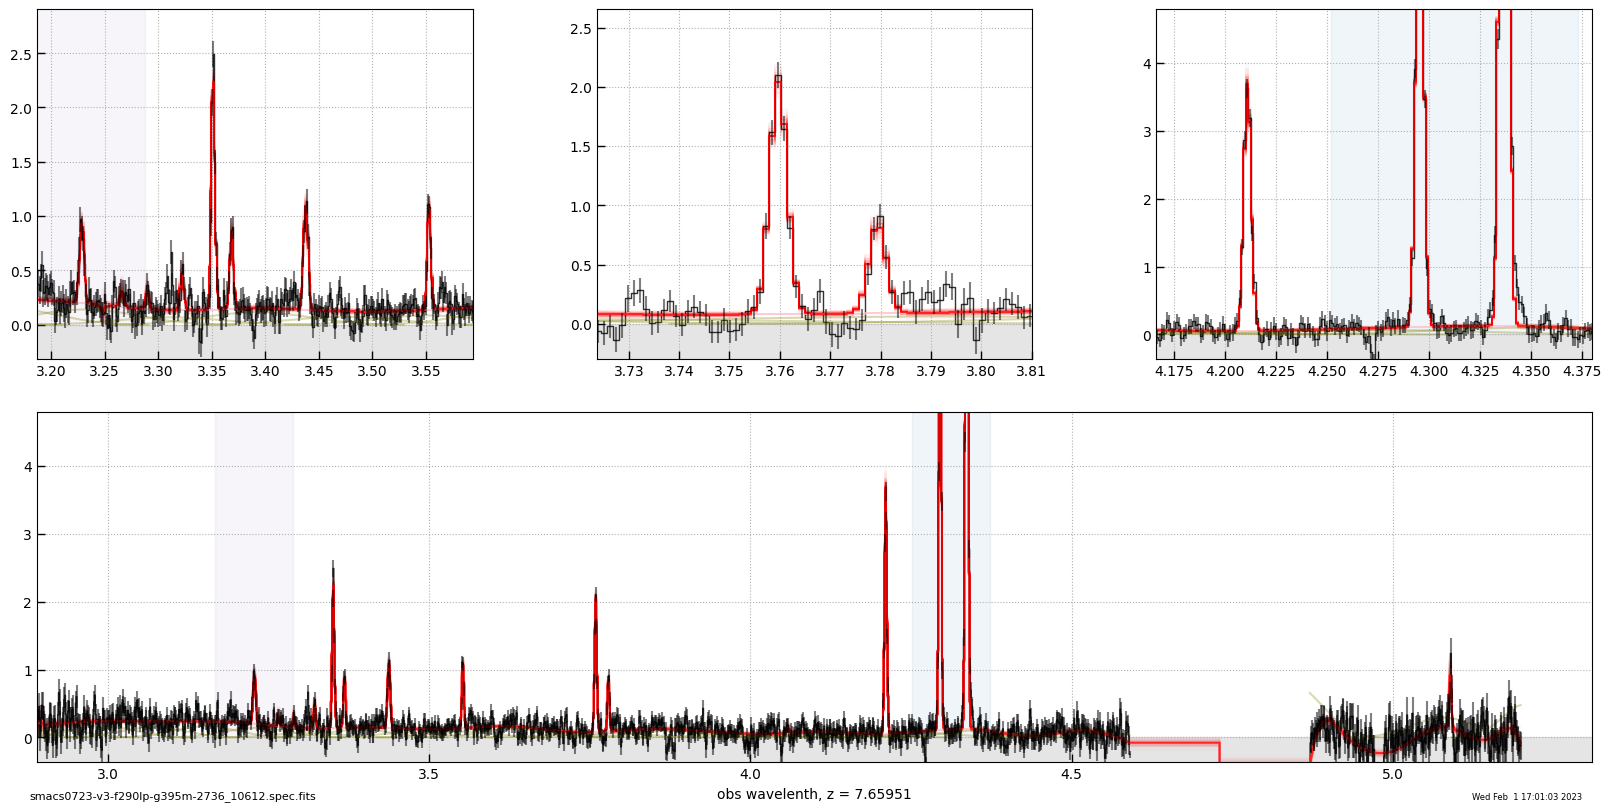

In [36]:
_ = spectrum.fit_redshift(file=f'{output_root}.spec.fits', z0=[6,9], 
                          eazy_templates=templ,
                          nspline=33,
                          scale_disp=1.0,
                          vel_width=10.,
                          is_prism=False,
                          use_full_dispersion=False,
                          ranges=[(3680, 4150), (4300, 4400), (4861-50, 5008+50)],
                         )

## More sources

f290lp-g395m 12
build_regular_wavelength_wcs: Set user-defined wavelength grid (size=2020)
Pad 2 pixels on 2D cutout


2023-02-01 17:01:06,985 - stpipe - INFO - Driz parameter kernal: square
2023-02-01 17:01:06,986 - stpipe - INFO - Driz parameter pixfrac: 1.0
2023-02-01 17:01:06,986 - stpipe - INFO - Driz parameter fillval: 0
2023-02-01 17:01:06,986 - stpipe - INFO - Driz parameter weight_type: ivm
2023-02-01 17:01:07,387 - stpipe - INFO - Resampling science data
2023-02-01 17:01:07,410 - stpipe - INFO - Drizzling (39, 89) --> (53, 2020)
2023-02-01 17:01:07,412 - stpipe - INFO - Resampling var_rnoise
2023-02-01 17:01:07,436 - stpipe - INFO - Drizzling (39, 89) --> (53, 2020)
2023-02-01 17:01:07,439 - stpipe - INFO - Resampling var_poisson
2023-02-01 17:01:07,463 - stpipe - INFO - Drizzling (39, 89) --> (53, 2020)
2023-02-01 17:01:07,466 - stpipe - INFO - Resampling var_flat
2023-02-01 17:01:07,490 - stpipe - INFO - Drizzling (39, 89) --> (53, 2020)
2023-02-01 17:01:07,715 - stpipe - INFO - Resampling science data
2023-02-01 17:01:07,738 - stpipe - INFO - Drizzling (39, 89) --> (53, 2020)
2023-02-01 17

Set prf_center: -3.5 (53, 2020) 12
fit_prf: center = -3.31. sigma = 2.00


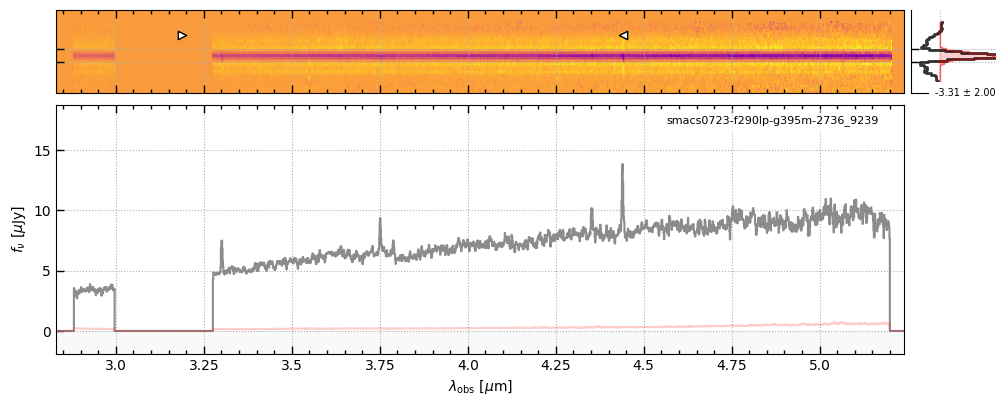

In [37]:
key = pipe.targets[0]

key = '2736_9239'

hdus = {}
for g in gratings:
    slits = []
    for pipe in gratings[g]:
        _slits = pipe.get_background_slits(key)
        if _slits is not None:
            slits.extend(_slits)
            
    print(g, len(slits))
    
    output_root = f'smacs0723-{g}-{key}'

    hdus[g] = msaexp.utils.drizzle_2d_pipeline(slits, drizzle_params=drizzle_params,
                                        profile_slice=slice(int(200*scale), int(900*scale)),
                                        standard_waves=scale,
                                        outlier_threshold=10,
                                        output_root=output_root,
                                        fit_prf=True, prf_center=None, prf_sigma=1.1, center_limit=8)

    
    fig = msaexp.utils.drizzled_hdu_figure(hdus[g], output_root=output_root, ny=None)


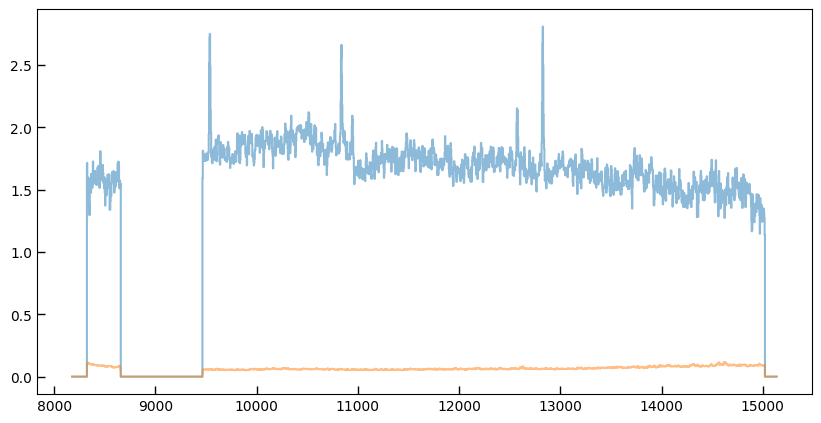

In [38]:
import grizli.utils

fig, ax = plt.subplots(1,1,figsize=(10,5))

z = 2.272e4/6564.-1

for g in hdus:
    sp = grizli.utils.GTable(hdus[g]['SPEC1D'].data)
    ax.step(sp['wave']/(1+z)*1.e4, sp['flux']*(sp['wave']/2.)**-2, alpha=0.5, where='mid')
    ax.step(sp['wave']/(1+z)*1.e4, sp['err']*(sp['wave']/2.)**-2, alpha=0.5, where='mid')
    
#ax.set_xlim(2.25, 2.3)
# ax.set_xlim(9000, 1.4e4)

f290lp-g395m 4
build_regular_wavelength_wcs: Set user-defined wavelength grid (size=2020)
Pad 2 pixels on 2D cutout


2023-02-01 17:01:14,988 - stpipe - INFO - Driz parameter kernal: square
2023-02-01 17:01:14,989 - stpipe - INFO - Driz parameter pixfrac: 1.0
2023-02-01 17:01:14,990 - stpipe - INFO - Driz parameter fillval: 0
2023-02-01 17:01:14,995 - stpipe - INFO - Driz parameter weight_type: ivm
2023-02-01 17:01:15,416 - stpipe - INFO - Resampling science data
2023-02-01 17:01:15,462 - stpipe - INFO - Drizzling (39, 988) --> (42, 2020)
2023-02-01 17:01:15,477 - stpipe - INFO - Resampling var_rnoise
2023-02-01 17:01:15,557 - stpipe - INFO - Drizzling (39, 988) --> (42, 2020)
2023-02-01 17:01:15,579 - stpipe - INFO - Resampling var_poisson
2023-02-01 17:01:15,630 - stpipe - INFO - Drizzling (39, 988) --> (42, 2020)
2023-02-01 17:01:15,653 - stpipe - INFO - Resampling var_flat
2023-02-01 17:01:15,703 - stpipe - INFO - Drizzling (39, 988) --> (42, 2020)
2023-02-01 17:01:15,988 - stpipe - INFO - Resampling science data
2023-02-01 17:01:16,012 - stpipe - INFO - Drizzling (34, 227) --> (42, 2020)
2023-02-

Set prf_center: -2.0 (42, 2020) 5
fit_prf: center = -1.96. sigma = 1.13


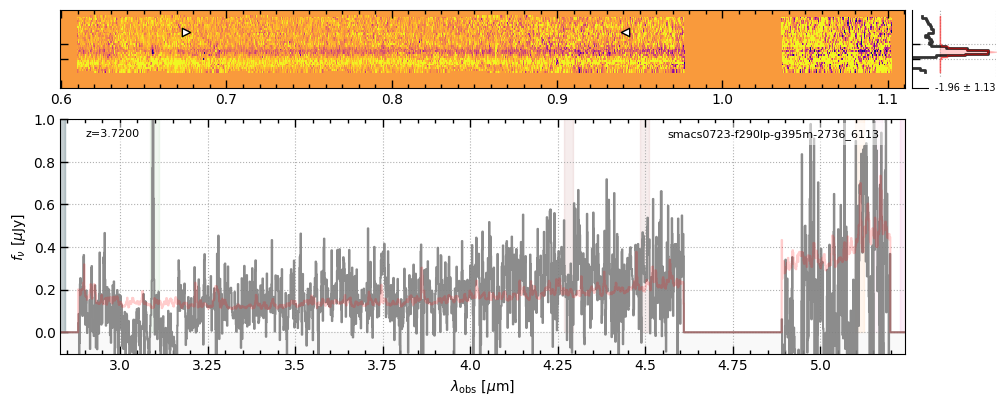

In [39]:
# Extract another object caught at the bottom of the slit (has ID 10511)
reload(msaexp.utils)

key = '2736_6113'

hdus = {}
for g in gratings:
    slits = []
    for pipe in gratings[g]:
        _slits = pipe.get_background_slits(key)
        if _slits is not None:
            slits.extend(_slits)
            
    print(g, len(slits))
    
    output_root = f'smacs0723-{g}-{key}'

    hdus[g] = msaexp.utils.drizzle_2d_pipeline(slits, drizzle_params=drizzle_params,
                                        profile_slice=slice(int(200*scale), int(900*scale)),
                                        standard_waves=scale,
                                        outlier_threshold=10,
                                        output_root=output_root,
                                        fit_prf=True, prf_center=None, prf_sigma=1.1, center_limit=12)

    
    fig = msaexp.utils.drizzled_hdu_figure(hdus[g], output_root=output_root, ny=None, ymax=1, z=3.72)
    fig.savefig(f'{output_root}.pdf')


In [40]:
key = '2736_9239'

output_root = f'smacs0723-{g}-{key}'

2023-02-01 17:01:17,459 - stpipe - WARNING - UnitsWarning: 'MICRONS' did not parse as fits unit: At col 0, Unit 'MICRONS' not supported by the FITS standard.  If this is meant to be a custom unit, define it with 'u.def_unit'. To have it recognized inside a file reader or other code, enable it with 'u.add_enabled_units'. For details, see https://docs.astropy.org/en/latest/units/combining_and_defining.html
2023-02-01 17:01:17,462 - stpipe - WARNING - UnitsWarning: 'MICRONS/PIXEL' did not parse as fits unit: At col 0, Unit 'MICRONS' not supported by the FITS standard.  If this is meant to be a custom unit, define it with 'u.def_unit'. To have it recognized inside a file reader or other code, enable it with 'u.add_enabled_units'. For details, see https://docs.astropy.org/en/latest/units/combining_and_defining.html
2023-02-01 17:01:17,464 - stpipe - WARNING - UnitsWarning: 'RESOLUTION' did not parse as fits unit: At col 0, Unit 'RESOLUTION' not supported by the FITS standard.  If this is me

2023-02-01 17:01:25,516 - stpipe - WARNING - UnitsWarning: 'RESOLUTION' did not parse as fits unit: At col 0, Unit 'RESOLUTION' not supported by the FITS standard.  If this is meant to be a custom unit, define it with 'u.def_unit'. To have it recognized inside a file reader or other code, enable it with 'u.add_enabled_units'. For details, see https://docs.astropy.org/en/latest/units/combining_and_defining.html



# line flux err
# flux x 10^-20 erg/s/cm2
# smacs0723-f290lp-g395m-2736_9239.spec.fits
# z = 2.46260
# Wed Feb  1 17:01:25 2023


2023-02-01 17:01:25,848 - stpipe - WARNING - UnitsWarning: 'MICRONS' did not parse as fits unit: At col 0, Unit 'MICRONS' not supported by the FITS standard.  If this is meant to be a custom unit, define it with 'u.def_unit'. To have it recognized inside a file reader or other code, enable it with 'u.add_enabled_units'. For details, see https://docs.astropy.org/en/latest/units/combining_and_defining.html
2023-02-01 17:01:25,850 - stpipe - WARNING - UnitsWarning: 'MICRONS/PIXEL' did not parse as fits unit: At col 0, Unit 'MICRONS' not supported by the FITS standard.  If this is meant to be a custom unit, define it with 'u.def_unit'. To have it recognized inside a file reader or other code, enable it with 'u.add_enabled_units'. For details, see https://docs.astropy.org/en/latest/units/combining_and_defining.html
2023-02-01 17:01:25,852 - stpipe - WARNING - UnitsWarning: 'RESOLUTION' did not parse as fits unit: At col 0, Unit 'RESOLUTION' not supported by the FITS standard.  If this is me


# line flux err
# flux x 10^-20 erg/s/cm2
# smacs0723-f290lp-g395m-2736_9239.spec.fits
# z = 2.46260
# Wed Feb  1 17:01:25 2023
      line SIII-9068        0.0 ±      0.0
      line SIII-9531      344.9 ±     14.1
            line PaD       28.7 ±     11.3
            line PaG      125.3 ±     11.8
            line PaB      403.7 ±     15.1
       line HeI-1083      302.1 ±     13.2


2023-02-01 17:01:27,079 - stpipe - WARNING - VerifyWarning: Keyword name 'flam_unit' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2023-02-01 17:01:27,081 - stpipe - WARNING - Attribute `flam_unit` of type <class 'astropy.units.quantity.Quantity'> cannot be added to FITS Header - skipping
2023-02-01 17:01:27,082 - stpipe - WARNING - VerifyWarning: Keyword name 'flux_unit' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2023-02-01 17:01:27,085 - stpipe - WARNING - Attribute `flux_unit` of type <class 'astropy.units.core.PrefixUnit'> cannot be added to FITS Header - skipping
2023-02-01 17:01:27,087 - stpipe - WARNING - VerifyWarning: Keyword name 'wave_unit' is greater than 8 characters or contains characters not allowed by the FITS standard; a HIERARCH card will be created.
2023-02-01 17:01:27,089 - stpipe - WARNING - Attribute `wave_unit` of ty

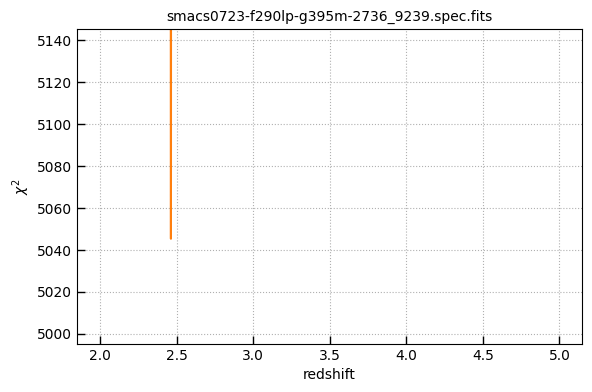

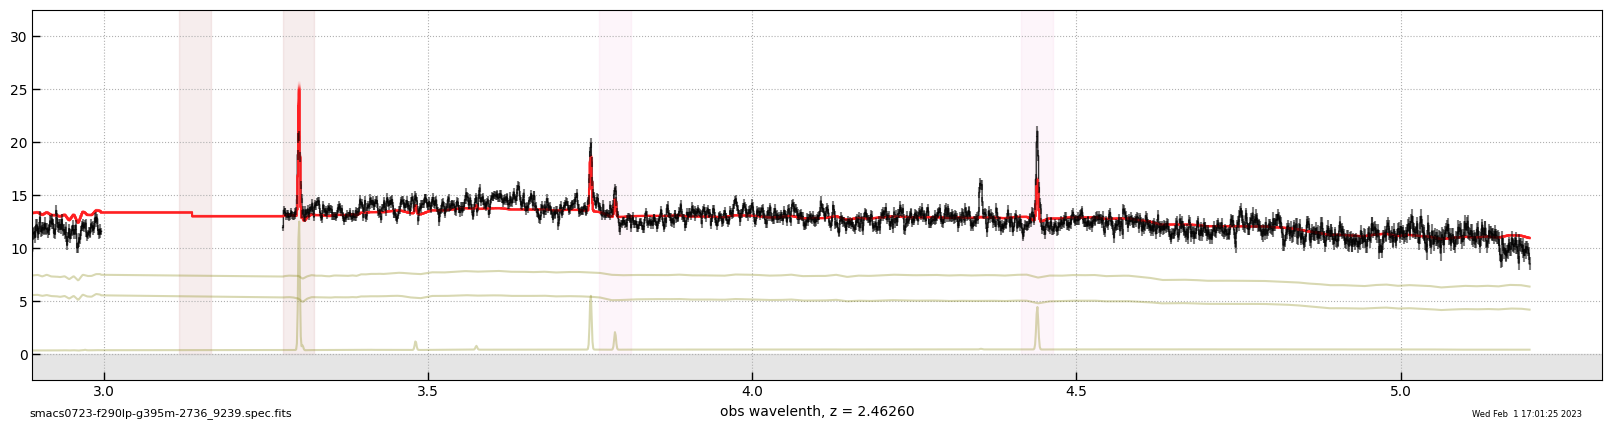

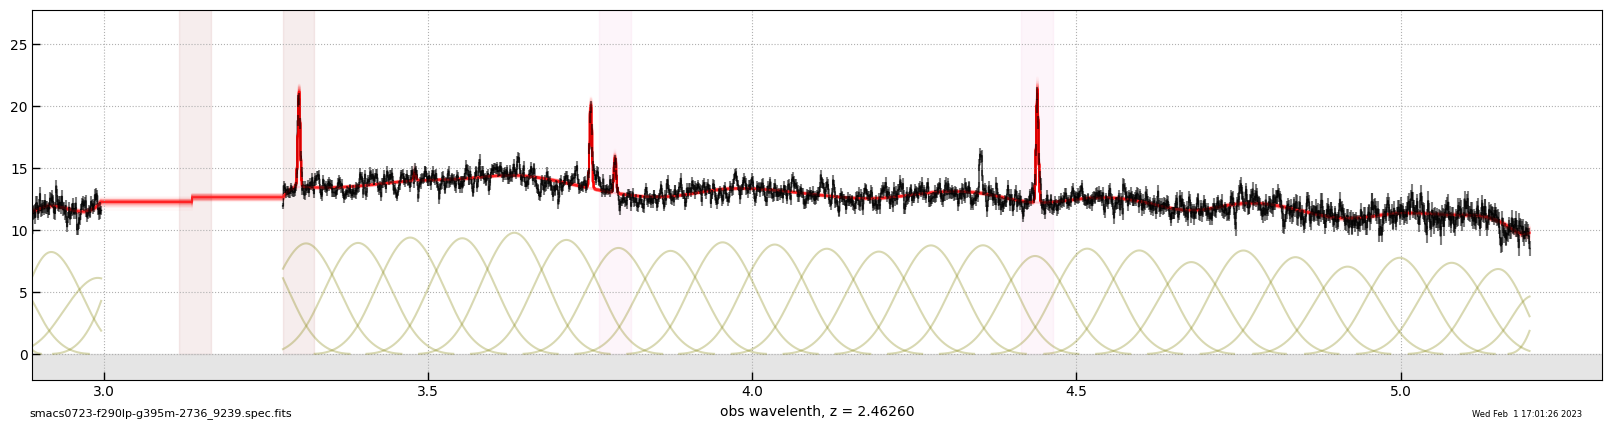

In [41]:
_ = spectrum.fit_redshift(file=f'{output_root}.spec.fits', z0=[2,5], 
                          eazy_templates=otempl,
                          nspline=33,
                          scale_disp=1.0,
                          vel_width=10.,
                          is_prism=False,
                          use_full_dispersion=False,
                          ranges=[(3680, 4150), (4300, 4400), (4861-50, 5008+50)],
                         )

Set SCALE_UNCERTAINTY:  [ 0.10732701 -1.36101748  5.62430738 -7.57417326]

# line flux err
# flux x 10^-20 erg/s/cm2
# smacs0723-f290lp-g395m-2736_9239.spec.fits
# z = 2.46260
# Wed Feb  1 17:01:28 2023
      line SIII-9068        0.0 ±      0.0
      line SIII-9531      343.0 ±     18.3
            line PaD       28.6 ±     16.5
            line PaG      125.1 ±     16.5
            line PaB      402.7 ±     15.8
       line HeI-1083      300.8 ±     17.9


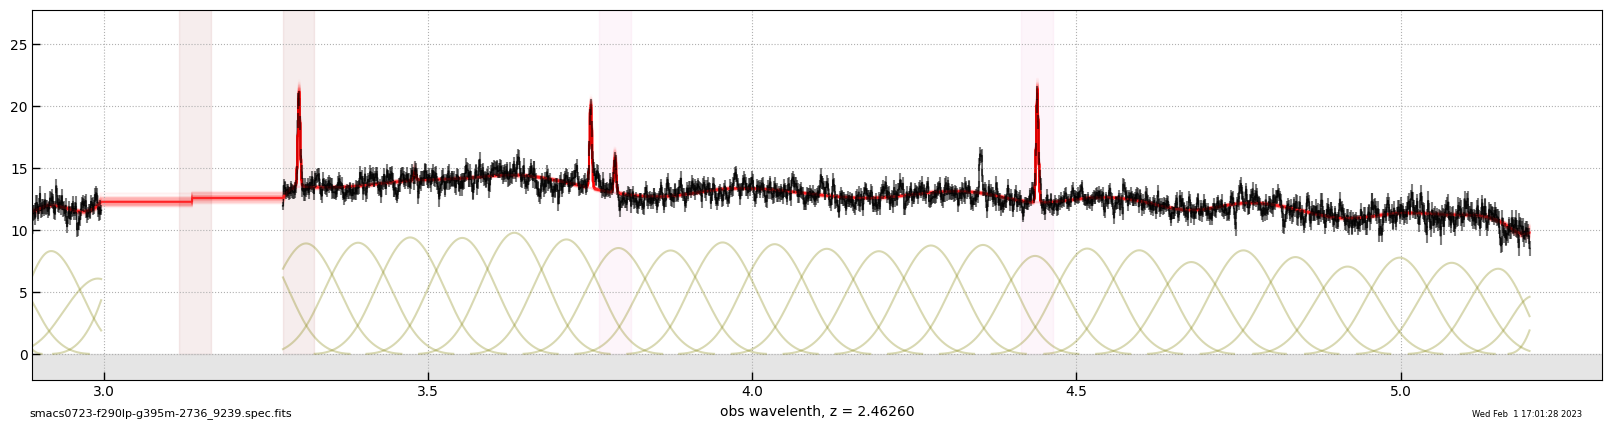

In [42]:
reload(spectrum)

spectrum.SCALE_UNCERTAINTY = 1.0

fig, sp, data = spectrum.plot_spectrum(file=f'{output_root}.spec.fits', 
                           z=_[2]['z'],
                          eazy_templates=None,
                          nspline=33,
                          scale_disp=1.0,
                          vel_width=10.,
                          is_prism=False,
                           scale_uncertainty_kwargs={'order':3, 'init':[1,3]},
                           use_full_dispersion=False,
                           Rline=5000,
                           ranges=[(3680, 4150), (4300, 4400), (4861-50, 5008+50)],
                         )

In [43]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
# carnall et al. and new redshifts
redshifts = {'2736_9922': 2.743,
             '2736_5144': 6.383,
             '2736_1917': 1.244,
             '2736_3772': 2.67e4/1.875e4-1, 
             '2736_4580': 3.09e4/5008.-1, # ?
             '2736_5735': 3.21e4/1.282e4-1,
             '2736_6113': 3.715,
             '2736_6355': 7.665,
             '2736_8140': 5.275,
             '2736_8506': 2.213,
             '2736_9236': 2.463,
             '2736_9483': 1.163,
             '2736_9721': 2.047e4/6564.-1,
             '2736_9922': 2.743,
             '2736_10612': 7.663,
             '2736_3042': 1.96e4/6564.-1,

             }

In [ ]:
# Looking at individual sources
ik = -1
targets

In [ ]:
key = targets[-1]
key = '2736_3042'

key = '2736_9922'
key = '2736_5144'
key = '2736_4798'
# key = '2736_4590'

#ik -= 3

ik += 1
key = targets[ik]

yoffset = 0.0
skip = []

for g in gratings:
    for pipe in gratings[g]:
        print(pipe.mode, key)
        if key == '2736_1370':
            yoffset = -4.0
            
        if key == '2736_8717':
            if '07001' in pipe.mode:
                skip = [0,1]
            else:
                skip = [0]
                
#         elif key == '2736_8506':
#             skip = [0]
            
#         elif key == '2736_8498':
#             yoffset = -12
            
#         if '07001' in pipe.mode:
#             skip = [0] # [0,1]
#             else:
#                 skip = [0]
                
#         elif key == '2736_3042':
#             yoffset = -14
#             skip = []
            
#         else:
#             skip = []
            
        try:
            _ = pipe.extract_spectrum(key, yoffset=yoffset, fit_profile_params=None, skip=skip)        
        except:
            plt.close('all')

In [ ]:
reload(msaexp.utils)

hdus = {}
for g in gratings:
    slits = []
    for pipe in gratings[g]:
        #_slits = pipe.get_background_slits(key, step='phot', check_background=False)
        _slits = pipe.get_background_slits(key) #, step='phot', check_background=False)
        if _slits is not None:
            slits.extend(_slits)
            
    print(g, len(slits))
    
    output_root = f'smacs0723-{g}_{key}_v3'

    hdus[output_root] = msaexp.utils.drizzle_2d_pipeline(slits, drizzle_params=drizzle_params,
                                        profile_slice=slice(int(200*scale), int(600*scale)),
                                        standard_waves=scale,
                                        outlier_threshold=10,
                                        output_root=output_root,
                                        fit_prf=False, prf_center=-0.4, prf_sigma=1.0, fix_sigma=True,
                                        #fit_prf=True, prf_center=-8., prf_sigma=1.0, fix_sigma=False,
                                        #fit_prf=True, prf_center=None, prf_sigma=1.0, fix_sigma=False,
                                                         center_limit=5)

    
    if key in redshifts:
        z = redshifts[key]
    else:
        z = None
    #z = 1.96e4/6564.-1

    fig = msaexp.utils.drizzled_hdu_figure(hdus[output_root], output_root=output_root, ny=None, z=z)


In [ ]:
z=3.21e4/1.282e4-1
z = 3.72
z = 2.047e4/6564.-1
z = 1.96e4/6564.-1

fig = msaexp.utils.drizzled_hdu_figure(hdus[output_root], output_root=output_root, ny=None, z=z)


In [ ]:
import grizli.utils

fig, ax = plt.subplots(1,1,figsize=(10,5))

if z is None:
    zi = 0.
else:
    zi = z

# zi = 3.715
    
for g in hdus:
    sp = grizli.utils.GTable(hdus[g]['SPEC1D'].data)
    ax.step(sp['wave']/(1+zi)*1.e4, sp['flux']*(sp['wave']/2.)**-2, alpha=0.5, where='mid')
    ax.step(sp['wave']/(1+zi)*1.e4, sp['err']*(sp['wave']/2.)**-2, alpha=0.5, where='mid')
    
#ax.set_xlim(2.25, 2.3)
# ax.set_xlim(9000, 1.4e4)
# ax.set_xlim(3600, 4400); ax.set_ylim(-0.05, 0.5)
# ax.set_xlim(4500, 8800); ax.set_ylim(-0.05, 1.5)
#ax.set_xlim(9000, 9800); ax.set_ylim(-0.05, 0.5)
#ax.set_xlim(9000, 18000); ax.set_ylim(-0.05, 0.5)


## Save any updates to the slit logs

In [ ]:
for g in gratings:
    for pipe in gratings[g]:
        pipe.parse_slit_info()

## Slit regions

In [ ]:
for k in pipe.slitlets:
    sd = pipe.slitlets[k]
    dr = (sd['source_ra'] - sd['slit_ra'])*np.cos(sd['source_dec']/180*np.pi)*3600
    dd = (sd['source_dec'] - sd['slit_dec'])*3600
    
    plt.scatter(dr, dd, alpha=0.1)
    

In [ ]:
from tqdm import tqdm
reload(msaexp.utils)

self = gratings[g][0]

slit_key = self.last_step
pipe = self.pipe[slit_key]

regs = []
for j in range(self.N):
    regs.append([])

include_yoffset = False

for key in tqdm(self.slitlets):
    slitlet = self.slitlets[key]
    #slitlet['bkg_index'], slitlet['src_index'], slitlet['slit_index']

    i = self.slit_index(key) # slitlet['slit_index']

    yoffset = slitlet['yoffset']

    dr = slitlet['source_ra'] - slitlet['slit_ra']
    dd = slitlet['source_dec'] - slitlet['slit_dec']

    for j in range(self.N):
        _slit = pipe[j].slits[i]
        _wcs = _slit.meta.wcs
        sh = _slit.data.shape
        
        rc, dc = msaexp.utils.get_slit_corners(_slit)
        
        xy = np.array([rc+dr, dc+dd])
        
        sr = grizli.utils.SRegion(xy)
        _name = slitlet['source_name']

        if '_m' in _name:
            sr.ds9_properties = 'color=yellow'
        elif 'b' in _name:
            sr.ds9_properties = 'color=white'
        else:
            sr.ds9_properties = 'color=green'

        if j == 0:
            sr.label = _name
            sr.ds9_properties += ' width=2'

        regs[j].append(sr)

_slitreg = f'{self.mode}.slits.reg'
print(_slitreg)
with open(_slitreg, 'w') as fp:
    for j in range(self.N):
            fp.write('icrs\n')
            for sr in regs[j]:
                fp.write(sr.region[0]+'\n')


In [ ]:
slit = slits[0]

In [ ]:
from gwcs import wcstools
for slit in slits:
    sh = slit.data.shape

    _wcs = slit.meta.wcs

    s2d = _wcs.get_transform('slit_frame', 'detector')
    d2s = _wcs.get_transform('detector', 'slit_frame')
    s2w = _wcs.get_transform('slit_frame', 'world')
    d2w = _wcs.get_transform('detector', 'world')

    bbox = _wcs.bounding_box
    grid = wcstools.grid_from_bounding_box(bbox)
    _, sy, slam = np.array(d2s(*grid))

    smi = np.nanmin(sy)
    sma = np.nanmax(sy)

    slit_x = np.array([-0.5, 0.5, 0.5, -0.5])
    slit_y = np.array([smi, smi, sma, sma])

    ra_corner, dec_corner, _w = s2w(slit_x, slit_y, np.nanmedian(slam))

    plt.plot(ra_corner, dec_corner)
    plt.scatter(slit.source_ra, slit.source_dec, marker='x')

In [ ]:
np.median(slam)